In [1]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

**Please write your name below** (in case the file names get mixed up)

Author: Mario Roca

# Clustering

## Probably not K-Means

Remember that in lab 1, we stumbled upon a dataset with two clearly identified clusters, but which K-Means could not usefully separate, because the delimitations were non-linear.

In [2]:
from sklearn import datasets
X_moons, y_moons = sklearn.datasets.make_moons(n_samples=200, shuffle=True, noise=0.05, random_state=42)

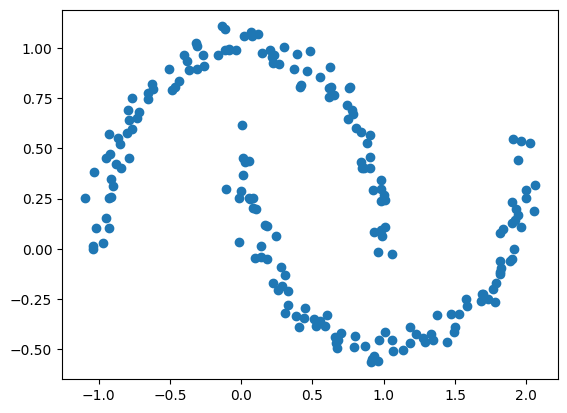

In [3]:
plt.scatter(X_moons[:,0], X_moons[:,1])
plt.show()

**Use a suitable clustering algorithm to assign each point to a cluster. Plot the result.**

You can consider that we know in advance how many clusters we want to obtain. You can (and maybe should) use an existing implementation.

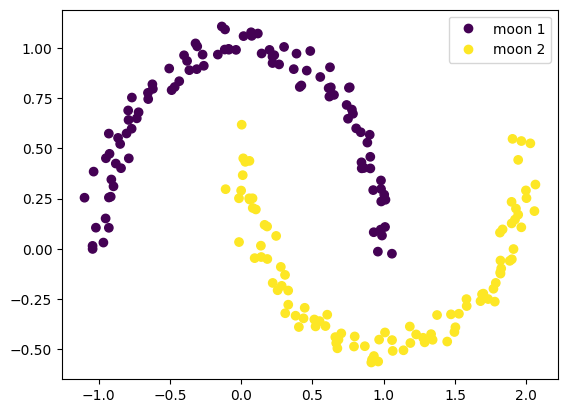

In [4]:
from sklearn.cluster import HDBSCAN

# I chose HDBSCAN from this overview https://scikit-learn.org/stable/modules/clustering.html 

hdb = HDBSCAN()
hdb.fit(X_moons)

scatter = plt.scatter(X_moons[:,0], X_moons[:,1], c=hdb.labels_)
plt.legend(scatter.legend_elements()[0], ['moon 1', 'moon 2'])
plt.show()

# Dimensionality reduction

## Data visualization

We will now use the MNIST dataset. It consists of 28x28 pixels images of handwritten digits, for total of 784 dimensions.

We could fetch the whole dataset with

In [5]:
# digits = fetch_openml(name='mnist_784')

However, we are not going to need the full dataset for this lab. Instead, let's load a prepared sample of 1000 handwritten digits.

In [6]:
# Load the dataset
# make sure that the file is located in the same folder as the notebook
# (or change the path)
digits = np.load("../Datasets/dataset.npz")

In [7]:
digits

NpzFile '../Datasets/dataset.npz' with keys: target, data, fives

In [8]:
# Define features as X and targets as y
X_digits, y_digits = digits["data"], digits["target"]
print(f"Matrix has dimension {X_digits.shape}")

Matrix has dimension (1000, 784)


Let's display some of the digits.

Conveniently, the first 10 samples are 0, 1, 2, ..., 9. The rest are in a random order.

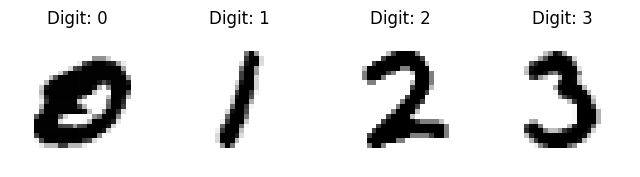

In [9]:
# Display the first 4 digits
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(8, 3)) # Create 4 subplots on 1 row
for ax, x, y in zip(axes, X_digits, y_digits):
    ax.set_axis_off() # do not display scale on axes
    img = x.reshape(28,28) # resize 784 dim vector as an 28 x 28 array of pixels
    ax.imshow(img, cmap=plt.cm.gray_r, vmin=0, vmax=1) # display image in gray scale, with values from 0 to 1
    ax.set_title(f"Digit: {y}")

**Apply PCA to obtained a representation $\mathbf{Z}$ of the data in 2 dimensions.**

You may use the implementation from scikit-learn.

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_digits)

print("Explained variance: ", pca.explained_variance_ratio_)   # Percentage of variance explained by each of the selected components
print("Singular values: ", pca.singular_values_)   # The singular values corresponding to each of the selected components

Explained variance:  [0.09943234 0.07765973]
Singular values:  [71.72943267 63.3915702 ]


**Plot the corresponding representation. Display the digits as different colors.**

Use a scatter plot. Optionnaly, you may print a legend to know which color correspond to which digit.

In [11]:
def plot_2D_digit_representation (X, method, y):
    """
        Scatter plot in 2D: color points by their digit label (0-9)
        
        Args:
            X: matrix of size N x D
            method: method used. Should be a string like "PCA", "t-SNE", "ISOMAP", etc.
            y: target labels
        """
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.nipy_spectral, edgecolor="k")

    # Add a color bar to show which color corresponds to which digit
    plt.colorbar(scatter, ticks=range(10), label='Digit Label')

    # Set axis labels
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')


    plt.title(f'MNIST dataset reduced to 2D using {method}')
    plt.show()

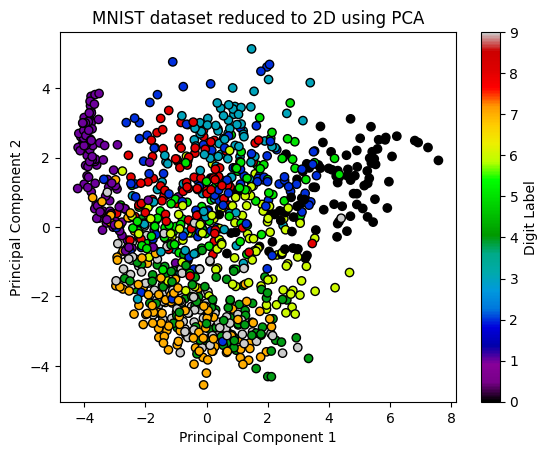

In [12]:
X_digits_pca = pca.transform(X_digits)
plot_2D_digit_representation(X_digits_pca, "PCA", y_digits)


**Are there any hyper-parameters? If yes, which one(s) did you choose?**.

*The most important hyper-parameter of PCA is the number of principal components (dimensions) to keep. In this exercise we selected 2. The values most used are 2 and 3 for visual representation in 2D and 3D graph. But higher dimensions can be chosen. The overall rule is to take the minimum numner of component that preserve the most of the variance. We can look at this with the following graph:*

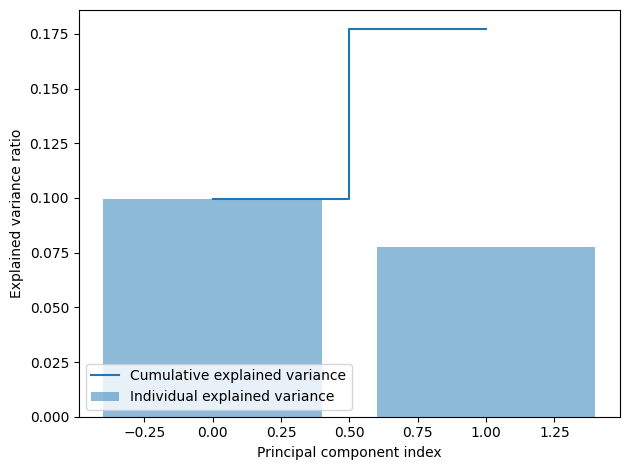

In [13]:
# Code source for this graph: https://vitalflux.com/pca-explained-variance-concept-python-example/
#  Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_
# Cumulative sum of eigenvalues; This will be used to create step plot for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization plot
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

**Now do the same things with t-SNE instead.**

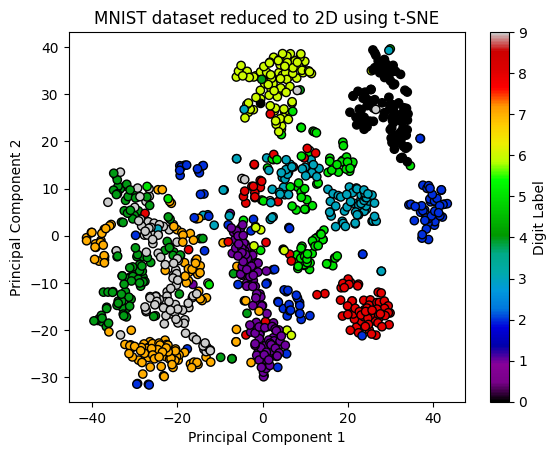

In [14]:
from sklearn.manifold import TSNE
X_digits_tSNE = TSNE(n_components=2).fit_transform(X_digits)

plot_2D_digit_representation(X_digits_tSNE, "t-SNE", y_digits)

**Are there any hyper-parameters? If yes, which one(s) did you choose?**.

*Apart from the number of components (dimensions), the t-SNE algorithm has an important parameter calle perplexity. The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. I left the default value = 30*

**Does one algorithm seem to give "better" results than the other? If yes, which one? Why may that be?** 

*It looks like the t-SNE performs better than PCA.
PCA is a linear dimensionality reduction technique. It projects the data onto a lower-dimensional space by finding directions (principal components) that maximize variance, assuming that the data lies on a straight (linear) subspace.
t-SNE, on the other hand, is a non-linear technique. It tries to preserve local distances and capture the underlying structure of the data, even when the data lies on a complex, curved manifold. MNIST data is high-dimensional and contains non-linear relationships between the pixel intensities, which t-SNE is better equipped to capture.*


**Just for fun, let's do the same thing with a 3rd dimensionality reduction method. You may pick the one you please.**

Maybe have a look at this documentation: https://scikit-learn.org/dev/modules/manifold.html#manifold-learning

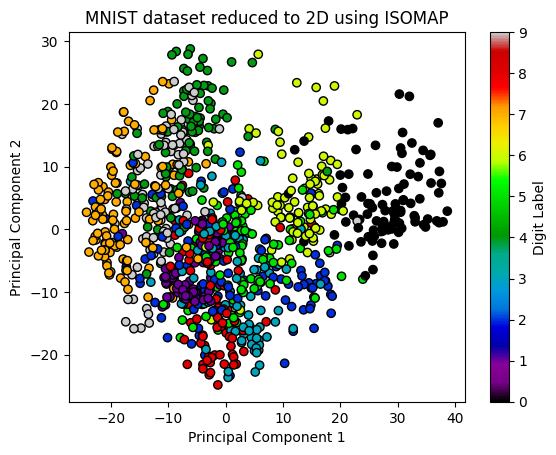

In [15]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_digits_isomap = isomap.fit_transform(X_digits)

plot_2D_digit_representation (X_digits_isomap, "ISOMAP", y_digits)

## Data generation

We have seen that we are able to identify some structure in the data. Now let's use this structure to generate new samples!

We will generate some handwritten '5s'.

Since there aren't that many 5s in the initial dataset with 1000 samples, let's load some additional images of 5.

In [16]:
X_five = digits["fives"]
print(f"Matrix has dimension {X_five.shape}")

Matrix has dimension (6313, 784)


In [17]:
def plot_some_images(X, title):
    # Display the first 4 fives
    _, axes = plt.subplots(nrows=1, ncols=4, figsize=(8, 3)) # Create 4 subplots on 1 row
    for ax, x in zip(axes, X):
        ax.set_axis_off()
        img = x.reshape(28,28)
        ax.imshow(img, cmap=plt.cm.gray_r, vmin=0, vmax=1)
    plt.title(f"{title}")

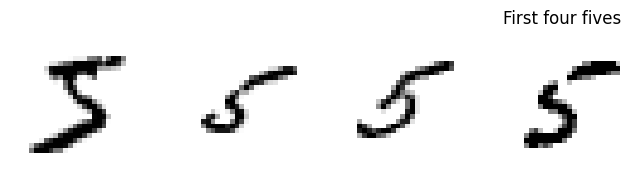

In [18]:
plot_some_images(X_five, "First four fives")

**What does the "average" 5 look like?**

*It's an handwritten digit pixelized on a 28x28 pixel image.*

To help you make a hopefully clear link between the slides from the lecture and an actual implementation of PCA, I provided a **commented implementation** of PCA that is reasonably close to what we covered in class. You will find it at the end of this notebook.

The name of the functions and attributes I use are the same as the ones from scikit-learn, to not induce any confusion.

You are free to use either this version, or the one from scikit-learn while using this as a reference to what is happening behind the scene. You are also free to not look at it at all, do as you please.

**Apply PCA to obtained a representation $\mathbf{Z}$ of the data in 2 dimensions. Then, apply the reverse transformation to reconstruct $\hat{\mathbf{X}}$ in 784 dimensions from its low dimension representation.**

**Important**: you need to reconstruct $\hat{\mathbf{X}}$ *from* $\mathbf{Z}$.

In [19]:
pca_5 = PCA(n_components=2)
X_fives_pca = pca_5.fit_transform(X_five)
print(f"Matrix has dimension {X_fives_pca.shape}")

inverse_fives = pca_5.inverse_transform(X_fives_pca)
print(f"Matrix has dimension {inverse_fives.shape}")

Matrix has dimension (6313, 2)
Matrix has dimension (6313, 784)


**Display some samples from the original dataset, along with some reconstructed samples**

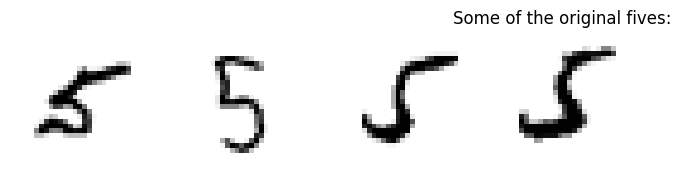

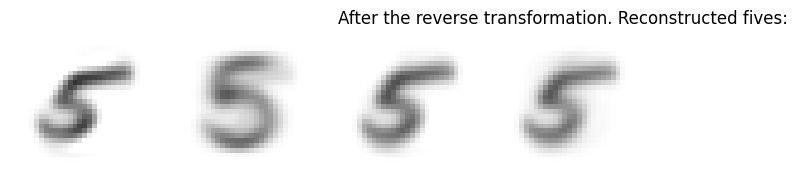

In [20]:
plot_some_images(X=X_five[1000:], title="Some of the original fives:")

plot_some_images(X=inverse_fives[1000:], title="After the reverse transformation. Reconstructed fives:")

**What do you notice?**

*After the transformation the images lost some quality. During the PCA reduction in fact, part of the information in fact is inevitably lost. Notice that we can still recognize the fives in the reconstructed versions, hence the important part of the information is still there.*

**Now do the same, but this time keeping 10 dimensions (i.e. 10 principal components), then 50, then 200 (out of 784).**

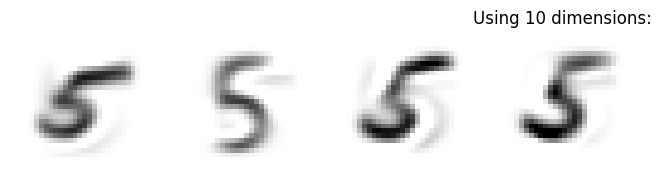

In [21]:
pca_10 = PCA(n_components=10)
X_fives_pca_10 = pca_10.fit_transform(X_five)

inverse_fives_10 = pca_10.inverse_transform(X_fives_pca_10)
plot_some_images(inverse_fives_10[1000:], "Using 10 dimensions:")

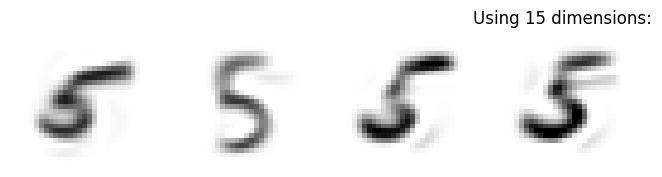

In [22]:
# 50 components make my kernel fail. Using 15 instead
pca_15 = PCA(n_components=15)
X_fives_pca_15 = pca_15.fit_transform(X_five)

inverse_fives_15 = pca_15.inverse_transform(X_fives_pca_15)
plot_some_images(inverse_fives_15[1000:], "Using 15 dimensions:")

In [23]:
# 200 components make my kernel fail. Not enough resources available.

# pca_200 = PCA(n_components=200)
# X_fives_pca_200 = pca_200.fit_transform(X_five)

# inverse_fives_200 = pca_200.inverse_transform(X_fives_pca_200)

# plot_some_images(inverse_fives_200, "Using 200 dimensions:")


**Do you notice a trend?**

*The more the dimensions the more similar the reconstructed image is to the original version. If we would take all the 784 dimensions then no information would be lost and the reconstructed image would be the same as the original one.*

This can actually be quantified with *explained variance*: recall from class that the first principal component corresponds to the axis with the largest variance, corresponding to the largest eigenvalue. But there may still be some variance left in other directions in the data, that would require other principal components.
The second principal component is the one with the second largest variance. Using this component in addition to the first one enables us to capture, or "explain", a bit more of the total variance of the data. Adding the third principal component lets us explain even more variance, and so on.

We can consider that the total variance of the data is the sum of the variances along all axes. By summing the variance of all principal components and dividing by the total variance, we can thus measure what percentage of the total variance we can explain with a given number of principal components.

In [24]:
# Measuring the explained variance for different numbers of principal components
for P in [2,10]: # 50, 200
    pca = PCA(n_components=P)
    Z = pca.fit_transform(X_five)
    # we use the explained variance method:
    # this gives us the explained variance for each of our P components,
    # normalized so that the total variance for P=D would be 1.
    explained_variance = pca.explained_variance_ratio_.sum()
    print(f"Explained variance with {P} components: {explained_variance:.3f}")

Explained variance with 2 components: 0.262
Explained variance with 10 components: 0.554


As you can see, using only 2 components only captures about a quarter of the total variance. This explains why reconstructed fives are quite different: we are missing quite a lot of information.

On the other hand, with 200, we capture 97%+ of the variance: the reconstructed fives are almost identical to the original ones. But we have "reduced the dimension a lot less", since we still have 200 dimensions in our reduced dataset.

Finally, using 784 components (as many as the initial dimension of the data) would enable us to have 100% explained variance, but at the cost of not having reduced the dimension of the data at all.

**Find the number of components needed to explain at least 50% of the variance.**

In [25]:
pca = PCA(n_components=0.5)

# Commenting to avoid Kernel crash

# pca.fit(X_five)
# pca.components_


Remember that the principal components should be independant (or more exactly, uncorrelated). We can therefore sample some data independently along each axis, and combine the sampled vectors to approximately match the distribution of the dataset.

**Using a vector space with the same number of dimensions, generate vectors along the principal components independently. Then, use these reduced dimension representations to reconstruct samples in the original image space.**

This is probably the hardest question you have met in this class (so far). Do not hesitate to ask for help.

Hint: if you use the scikit-learn implementation, there is a parameter whose default value should be changed to ensure that your coordinates z in principal component space have unit variance.

You may want to check the doc: https://scikit-learn.org/dev/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA
    
In general, it is a good habit to look at the documentation of the implementations we are using, to ensure that everything behaves as we expect by default, and that we are not missing something important.

**Plot the resulting images.**

**Are all the generated numbers indistinguishable from the original numbers?**

***Optional: what may be the reason?***

### Appendix: implementation of PCA

In [26]:
class MyPCA:
    """
    Implementation of PCA similar to scikit-learn
    """
    
    def __init__(self, n_components: int=2) -> None:
        """
        Init
        
        Args:
            n_components: P
        """
        self.n_components = n_components # P
        # Initialize empty attributes
        self.mean_ = None
        self.singular_values_ = None
        self.components_ = None
        
    def fit(self, X: np.ndarray) -> None:
        """
        Compute principal components from data
        
        Args:
            X: matrix of size N x D
            
        Result (stored):
            mean_: mu, vector of size D
            singular_values_: lambdas, vector of size P
            components_: matrix P, matrix of size P x D
        """
        N, D = X.shape
        self.mean_ = X.mean(axis=0) # mean (mu)
        X = X - self.mean_ # center: substract mean
        
        # Implementation from class: actually not robust
        """
        cov = X.T @ X / N # compute covariance matrix
        values, components = np.linalg.eig(cov) # get eigen values/vectors
        self.singular_values_ = np.sqrt(values)[:self.n_components] # keep first P singular values
        self.components_ = components.T[:self.n_components] # keep first P principal components
        """
        # Alternative implementation with SVD
        U, S, Vt = np.linalg.svd(X, full_matrices=False)  # U: N x N, S: min(N, D), Vt: D x D
        self.singular_values_ = S[:self.n_components] # keep first P singular values
        self.singular_values_ = self.singular_values_  / np.sqrt(N) # SVD does not normalize w.r.t. sample size
        self.components_ = Vt[:self.n_components] # keep first P principal components
    
    def transform(self, X: np.ndarray) -> np.ndarray:
        """
        Return coordinates of input in principal components basis
        
        Args:
            X: matrix of size N x D, coordinates in high-dim space
            
        Returns:
            Z: matrix of size N x P, coordinates in p.c. space
        """
        X = X - self.mean_ # center: substract mean
        Z = X @ self.components_.T  # project to p.c. basis
        return Z / self.singular_values_  # scale by singular values
    
    def inverse_transform(self, Z: np.ndarray) -> np.ndarray:
        """
        Maps back to high-dim space from coordinates in p.c. space
        
        Args:
            Z: matrix of size N x P, coordinates in p.c. space
                    
        Returns:
            X: matrix of size N x D, coordinates in high dim space
        """
        Z = Z * self.singular_values_ # "un-normalize" standard deviations
        X = Z @ self.components_ # compute coordinates in initial space
        return X + self.mean_ # "uncenter" by adding the mean
    
    def fit_transform(self, X: np.ndarray) -> np.ndarray:
        """
        Combination of fit and transform
        """
        self.fit(X)
        return self.transform(X)